# Three-Stage Hybrid Recommendation System for Personalized Skincare

In this project, the development of the skincare recommendation system will use the product catalog from Chemist Warehouse, the largest pharmacy in Australia that offers the most extensive range of skincare products. To enrich the product catalog, an ingredients database from Renude, an online skincare service, was incorporated to provide more precise information about each product. The model will enable analyzing the details of each product and user requirements to improve accessibility for users in finding the best-matched product.

# 1. Web Scraping

The process begin with **web scraping to retrieve product catalog data from the Chemist Warehouse website**, specifically for the skincare category. We collected only the necessary information required to meet user requirements, ensuring alignment and efficient data cleaning.

To enrich information about each product’s benefits and potential allergens, we performed **additional web scraping for ingredient details from Renude, an online skincare service** that also provides personalized multi-brand skincare routines through AI skin analysis.

In [1]:
import sys
import time
import re
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from urllib.parse import unquote, urlparse, parse_qs
from selenium.common.exceptions import TimeoutException, WebDriverException
from bs4 import BeautifulSoup

BASE_URL = "https://www.chemistwarehouse.com.au"

def setup_driver():
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")
    options.add_argument("--window-size=1920,1080")
    
    return webdriver.Chrome(options=options)

def get_product_links(driver, page_url):

    driver.get(page_url)
    time.sleep(1)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.mt-space-heading-body"))
        )
    except TimeoutException:
        return []

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # Retrieve data for each product block saved within the "mt-space-heading-body" divider
    product_containers = soup.select('div.mt-space-heading-body')
    
    products = []

    # Get product name and link
    for container in product_containers:
        a_tag = container.select_one('p.body-s a.focus-visible\\:outline-none')

        img_tag = soup.find("img", src=lambda x: x and "/_next/image" in x)

        if a_tag:
            # 1. Product name
            name = a_tag.text.strip()
            
            # 2. URL
            href = a_tag.get('href')
            full_url = BASE_URL + href if href else None
            
            # 3. Image
            img_url = None
            
            if img_tag:
                src = img_tag.get("src")
                try:
                    parsed_url = urlparse(src)
                    query_params = parse_qs(parsed_url.query)

                    if "url" in query_params:
                        img_url = unquote(query_params["url"][0])
                except:
                    img_url = src

        products.append((name, full_url, img_url))

    return products

def is_valid_url(url):
    if not url or not isinstance(url, str):
        return False
    if not url.startswith('http'):
        return False
    
    # URL validation
    try:
        parsed = urlparse(url)
        return bool(parsed.netloc and parsed.scheme)
    except:
        return False

def get_product_details(driver, product_url):

    if not product_url or not is_valid_url(product_url):
        print(f"Invalid URL: {product_url}")
        return {}


    driver.get(product_url)
    time.sleep(1)
    
    try:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.headline-xl.text-colour-title-light'))
            )
        except:
            return {}

        soup = BeautifulSoup(driver.page_source, "html.parser")

        details = {
                "name": None,
                "price": None,
                "rating": None,
                "reviews_count": None,
                "general_information": None,
                "ingredients": None
            }

        # 1. Product name
        name_tag = soup.select_one('h1.headline-xl.text-colour-title-light')
        details['name'] = name_tag.get_text(strip=True) if name_tag else None

        # 2. Price
        price_tag = soup.select_one('h2.display-l.text-colour-title-light')
        details['price'] = price_tag.get_text(strip=True) if price_tag else None

        # 3. Ratings and reviews count
        rating_tag = soup.select_one('span.text-colour-subtitle-light')
        if rating_tag:
            match = re.match(r'(\d+\.?\d*)\s*\((\d+)\)', rating_tag.get_text(strip=True))
            if match:
                details['rating'] = float(match.group(1))
                details['reviews_count'] = int(match.group(2))
            else:
                details['rating'] = None
                details['reviews_count'] = None
        else:
            details['rating'] = None
            details['reviews_count'] = None


        # 4. General Information & Ingredients
        buttons = soup.select('h3 > button[aria-label="toggle accordion"]')
        for btn in buttons:
            section_name = btn.get_text(strip=True).lower()
            content_id = btn.get('aria-controls')
            if not content_id:
                continue
            content_div = soup.find("div", id=content_id)
            if not content_div:
                continue
            
            text = content_div.get_text(separator="\n", strip=True)

            if "general information" in section_name:
                details["general_information"] = text

            elif "ingredients" in section_name:
                details["ingredients"] = text

        return details

    except WebDriverException as e:
        print(f"WebDriver error for {product_url}: {str(e)[:100]}...")
        return {}
    except Exception as e:
        print(f"Unexpected error for {product_url}: {str(e)[:100]}...")
        return {}

def main_scrapper_product(page_num=50, save_path='products_list.csv'):
    
    driver = setup_driver()

    try:
        BASE_CATALOG_URL = "https://www.chemistwarehouse.com.au/shop-online/665/skin-care"
        all_products = []
        all_details = []

        # Get product links
        page = 1
        for page in tqdm(range(1, page_num+1), desc="Pages scraped"):
            page_url = f"{BASE_CATALOG_URL}?page={page}"
            products = get_product_links(driver, page_url)
            
            if not products:
                break

            all_products.extend(products)

            page += 1

        print(f"\nTotal products found: {len(all_products)}\n")

        # Get product details
        for product in tqdm(all_products,desc="Scraping products", unit="product"):
            name, link, img_url = product

            if not is_valid_url(link):
                print(f"Invalid URL: {link}")
                continue

            details = get_product_details(driver, link)
            time.sleep(1)

            details["url"] = link
            details["img_url"] = img_url

            all_details.append(details)


       # Save results
        if all_details:
            df = pd.DataFrame(all_details)
            if save_path:
                try:
                    df.to_csv(save_path, index=False, encoding='utf-8')
                    print(f"Data saved to {save_path}")
                except Exception as e:
                    print(f"Failed to save CSV: {e}")
                    return all_details 
            return df
        
        return []

    finally:
        driver.quit()


In [ ]:
# Scrape ingredients data from Chemist Warehouse
product_df = main_scrapper_product()

Pages scraped: 100%|██████████| 50/50 [02:01<00:00,  2.44s/it]



Total products found: 1000



Scraping products: 100%|██████████| 1000/1000 [1:08:11<00:00,  4.09s/product]


Data saved to products_list.csv


In [14]:
import sys
import time
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from bs4 import BeautifulSoup

BASE_URL = "https://renude.co"

def setup_driver():
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")
    options.add_argument("--window-size=1920,1080")
    
    return webdriver.Chrome(options=options)

def get_ingredient_links(driver, page_url):
    
    driver.get(page_url)
    time.sleep(1)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a[href^='/ingredients/'] h3"))
        )
    except TimeoutException:
        return []

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # Retrieve ingredient name and link
    ingredient_containers = soup.select("a[href^='/ingredients/']")
    ingredients = []

    for container in ingredient_containers:
        name_tag = container.select_one("h3")
        if name_tag:
            name = name_tag.get_text(strip=True)
            link = BASE_URL + container.get('href')
            ingredients.append((name, link))
    
    return ingredients

def get_ingredient_details(driver, ingredient_url):

    if not ingredient_url or not is_valid_url(ingredient_url):
        print(f"Invalid URL: {ingredient_url}")
        return {}
    
    driver.get(ingredient_url)
    time.sleep(1)

    try:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "h2.font-patron"))
            )
        except:
            return {}
        
        soup = BeautifulSoup(driver.page_source, "html.parser")
        details = {
            "what_does": None,
            "good_for": None,
            "avoid": None
        }

        sections = soup.select("h2.font-patron")
        for section in sections:
            heading = section.get_text(strip=True)
            parent_div = section.find_parent("div")
            if not parent_div:
                continue
            text = parent_div.get_text(separator="\n", strip=True)

            # Clean each section
            if "what does" in heading.lower():
                # Remove "What does\nXXX\ndo?\n"
                parts = text.split("do?\n", 1)
                details["what_does"] = parts[1].strip() if len(parts) == 2 else text.strip()

            elif "good for" in heading.lower():
                # Remove header & repeated lines
                parts = text.split("might be a good option for you:", 1)
                details["good_for"] = parts[1].strip() if len(parts) == 2 else text.strip()

            elif "should avoid" in heading.lower():
                # Remove header & repeated lines
                parts = text.split("it might be best to avoid", 1)
                # remove any leading colons or newlines
                details["avoid"] = parts[1].lstrip(":\n").strip() if len(parts) == 2 else text.strip()

        return details
    
    except WebDriverException as e:
        print(f"WebDriver error for {ingredient_url}: {str(e)[:100]}...")
        return {}
    except Exception as e:
        print(f"Unexpected error for {ingredient_url}: {str(e)[:100]}...")
        return {}


def main_scraper_ingredients(page_num=18, save_path='ingredients_list.csv'):
    
    driver = setup_driver()

    try:
        INGREDIENTS_URL = f"{BASE_URL}/ingredients/"
        all_ingredients = []
        all_details = []

        page = 1
        # Get product links
        for page in tqdm(range(1, page_num+1), desc="Pages scraped"):
            page_url = f"{INGREDIENTS_URL}/page/{page}"
            ingredients = get_ingredient_links(driver, page_url)

            if not ingredients:
                break

            all_ingredients.extend(ingredients)

            page += 1

        print(f"\nTotal ingredients found: {len(all_ingredients)}\n")

        # Get ingredient details
        for name, link in tqdm(all_ingredients, desc="Scraping ingredient details", unit="ingredient"):

            if not is_valid_url(link):
                print(f"Invalid URL: {link}")
                continue
            
            details = get_ingredient_details(driver, link)

            details["ingredient_name"] = name
            details["url"] = link
            
            all_details.append(details)

        # Save results
        if all_details:
            df = pd.DataFrame(all_details)
            if save_path:
                try:
                    df.to_csv(save_path, index=False, encoding='utf-8')
                    print(f"Data saved to {save_path}")
                except Exception as e:
                    print(f"Failed to save CSV: {e}")
                    return all_details 
            return df
        
        return []

    finally:
        driver.quit()


In [ ]:
# Scrape ingredients data from Renude
ingredients_df = main_scraper_ingredients()

Pages scraped: 100%|██████████| 18/18 [00:33<00:00,  1.89s/it]



Total ingredients found: 260



Scraping ingredient details: 100%|██████████| 260/260 [09:14<00:00,  2.13s/ingredient]


Data saved to ingredients_list.csv


# 2. Load Dataset

The result from web scrapping have already been saved as a CSV file, and here we can reloaded the files for different runs.

In [1]:
### Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Load product list
product_df = pd.read_csv('products_list.csv')

print(f'Product dataset shape: {product_df.shape}')
product_df.head()

Product dataset shape: (1000, 8)


,name,price,rating,reviews_count,general_information,ingredients,url,img_url
0,Palmer's Shea Butter Body Oil 250ml,$6.99,5.0,5,Palmer's® Shea Formula® Body Oil soothes and n...,"Glycine Soja (Soybean) Oil, Isopropyl Myristat...",https://www.chemistwarehouse.com.au/buy/126944...,https://static.chemistwarehouse.com.au/ams/med...
1,La Roche Posay Cicaplast Baume B5+ 100ml,$36.99,4.7,544,Multi-repairing hydrating balm for dry skin.\n...,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...,https://www.chemistwarehouse.com.au/buy/122042...,https://static.chemistwarehouse.com.au/ams/med...
2,Avene Thermal Spring Water 300ml - Mist for Se...,$11.99,4.8,743,The unique and constant composition of Avène T...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...,https://www.chemistwarehouse.com.au/buy/71113/...,https://static.chemistwarehouse.com.au/ams/med...
3,Palmer's Shimmer Radiance Body Oil 150ml,$9.99,4.9,7,Palmer's Cocoa Butter Formula Shimmer Radiance...,"Mineral Oil (Paraffinum Liquidum), Isopropyl P...",https://www.chemistwarehouse.com.au/buy/143000...,https://static.chemistwarehouse.com.au/ams/med...
4,CeraVe Moisturising Cream 454g,$25.99,4.7,1545,RICH CREAM FOR DRY TO VERY DRY SKIN\nRICH CERA...,2021500 - INGREDIENTS: AQUA / WATER • GLYCERI...,https://www.chemistwarehouse.com.au/buy/91329/...,https://static.chemistwarehouse.com.au/ams/med...


In [3]:
### Load ingredient list
ingredients_df = pd.read_csv('ingredients_list.csv')

print(f'Ingredient dataset shape: {ingredients_df.shape}')
ingredients_df.head()

Ingredient dataset shape: (260, 5)


,ingredient_name,what_does,good_for,avoid,url
0,Acai Extract,"Provide antioxidant benefits to the skin, figh...",Pregnancy,Acai Extract\n:\nRelated Allergy,https://renude.co/ingredients/acai-extract
1,Acetylarginyltryptophyl Diphenylglycine,Acetylarginyltryptophyl Diphenylglycine is us...,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetylarginyltryptophyl Diphenylglycine\n:\nRe...,https://renude.co/ingredients/acetylarginyltry...
2,Acetyl Glucosamine,Acetyl Glucosamine is used in skincare to trea...,Dry and dehydrated skin\nElasticity\nFine Line...,Acetyl Glucosamine\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-glucosamine
3,Acetyl Tetrapeptide,Acetyl Tetrapeptide is used in skincare to tre...,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetyl Tetrapeptide\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-tetrapeptide
4,Acetyl Tyrosinamide,Acetyl Tyrosinamide is used in skincare to tre...,Elasticity\nFine Lines\nWrinkles,Acetyl Tyrosinamide\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-tyrosinamide


In [4]:
product_raw = pd.read_csv('products_list.csv')
product_raw[['name', 'general_information', 'ingredients']].head(3)

,name,general_information,ingredients
0,Palmer's Shea Butter Body Oil 250ml,Palmer's® Shea Formula® Body Oil soothes and n...,"Glycine Soja (Soybean) Oil, Isopropyl Myristat..."
1,La Roche Posay Cicaplast Baume B5+ 100ml,Multi-repairing hydrating balm for dry skin.\n...,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...
2,Avene Thermal Spring Water 300ml - Mist for Se...,The unique and constant composition of Avène T...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...


In [5]:
ingredients_raw = pd.read_csv('ingredients_list.csv')
ingredients_raw[['ingredient_name', 'good_for', 'avoid']].head(3)

,ingredient_name,good_for,avoid
0,Acai Extract,Pregnancy,Acai Extract\n:\nRelated Allergy
1,Acetylarginyltryptophyl Diphenylglycine,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetylarginyltryptophyl Diphenylglycine\n:\nRe...
2,Acetyl Glucosamine,Dry and dehydrated skin\nElasticity\nFine Line...,Acetyl Glucosamine\n:\nRelated Allergy


# 3. EDA

The process begins with initial data exploration for both product catalog and ingredients datasets. We checked for missing values, data distribution, and correlations between values.

## 1. Product dataframe exploration

In [6]:
# 1. Check for data type and missing values
summary_product = pd.DataFrame({
    "data_type": product_df.dtypes,
    "missing_values": product_df.isnull().sum()
})

summary_product

,data_type,missing_values
name,object,0
price,object,0
rating,float64,0
reviews_count,int64,0
general_information,object,60
ingredients,object,106
url,object,0
img_url,object,0


In [7]:
# 2. Check for duplicated data
print(f"Total number of duplicated rows: {product_df.duplicated(subset=["name"]).sum()}")

Total number of duplicated rows: 0


We found that `price` strored as object there's missing values in `general_information` and `ingredients`

### Statistics of numerical variables

In [8]:
# 1. Check statistics summary for numerical variables

# Convert price into numerical
product_df['price'] = product_df['price'].str.replace('$', '').astype(float)

product_df.describe()

,price,rating,reviews_count
count,1000.000000,1000.000000,1000.000000
mean,19.130670,4.813600,182.795000
std,20.820009,0.132335,1038.311477
min,2.140000,4.500000,1.000000
25%,8.915000,4.700000,6.000000
50%,14.840000,4.800000,28.000000
75%,22.990000,5.000000,102.000000
max,399.000000,5.000000,25959.000000


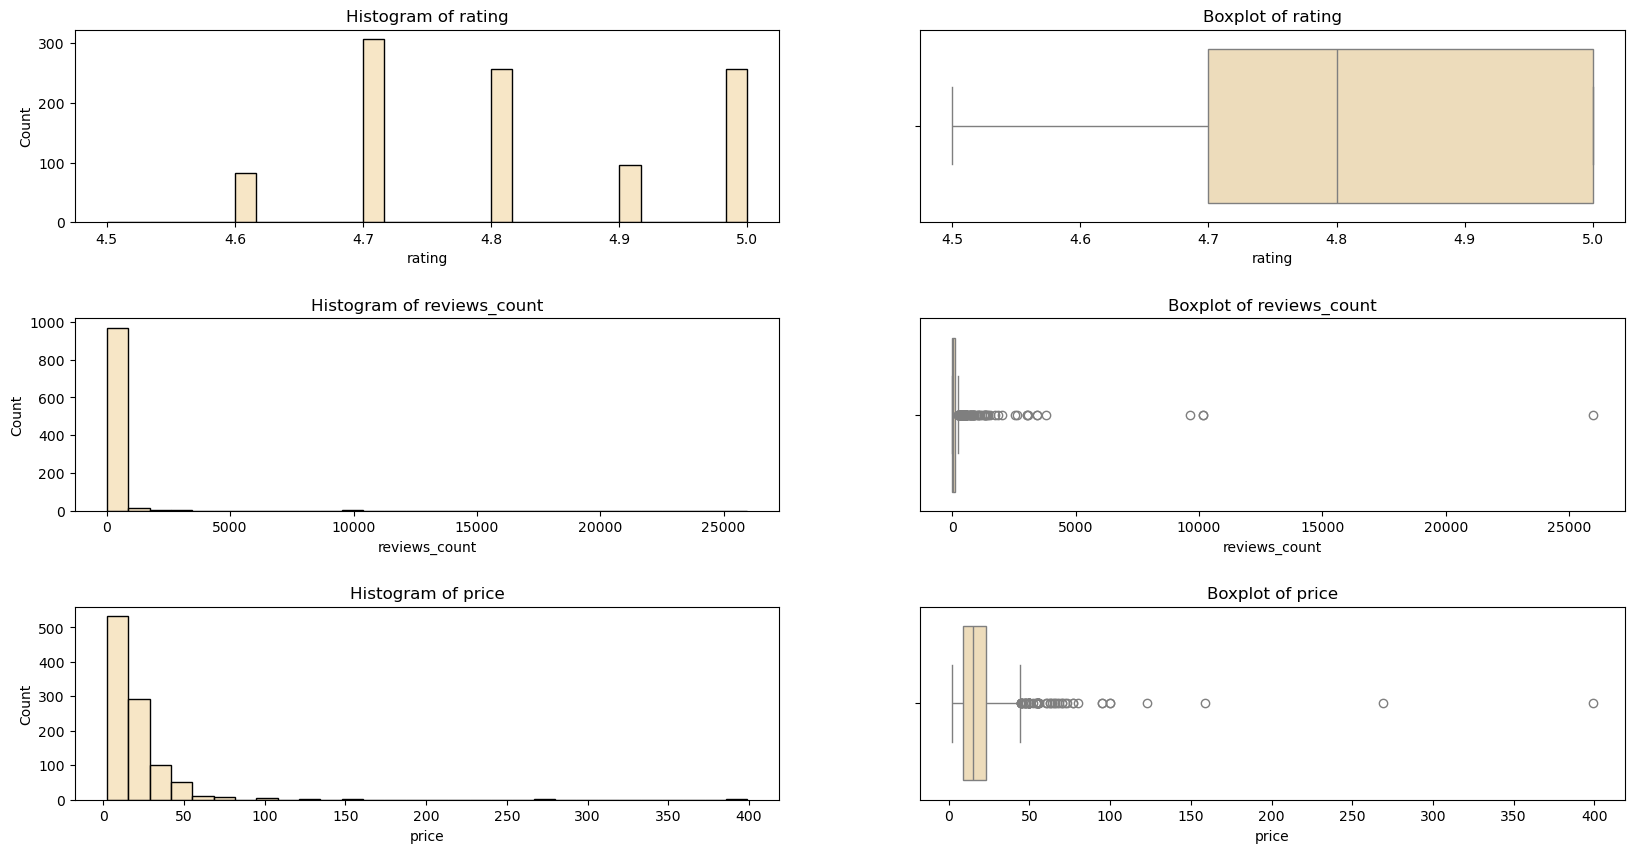

In [9]:
# 2. Distribution in numerical features

numeric_features = ['rating', 'reviews_count', 'price']

fig, axes = plt.subplots(len(numeric_features), 2, figsize=(20, 10))

for n, feat in enumerate(numeric_features):
    color = "wheat"

    # Histogram
    sns.histplot(product_df[feat], bins=30, kde=False, color=color, ax=axes[n, 0])
    axes[n, 0].set_title(f'Histogram of {feat}')

    # Boxplot
    sns.boxplot(x=product_df[feat], color=color, ax=axes[n, 1])
    axes[n, 1].set_title(f'Boxplot of {feat}')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

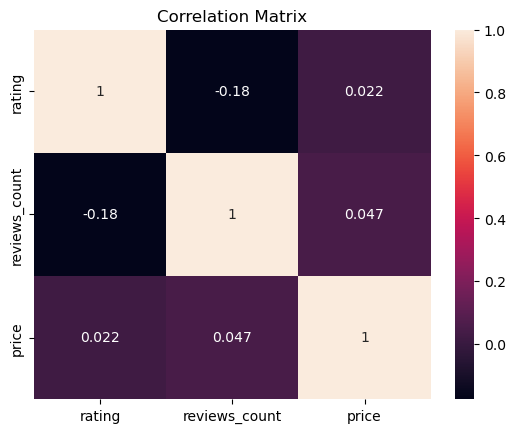

In [10]:
# 3. Correlation between numerical features (bivariate analysis)
sns.heatmap(product_df[['rating', 'reviews_count', 'price']].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

## 2. Ingredients dataframe exploration

In [11]:
# 1. Check for data type and missing values
summary_ingredients = pd.DataFrame({
    "data_type": ingredients_df.dtypes,
    "missing_values": ingredients_df.isnull().sum()
})

summary_ingredients

,data_type,missing_values
ingredient_name,object,0
what_does,object,2
good_for,object,3
avoid,object,2
url,object,0


In [12]:
# 2. Check for duplicated data
print(f"Total number of duplicated rows: {ingredients_df.duplicated(subset=["ingredient_name"]).sum()}")

Total number of duplicated rows: 0


# 4. Data Preparation

In this section, we perform data cleaning, data trasnformation, and feature engineering to connect the ingredients list to the product catalog.

## 1. Data Cleaning

### (a) Product list dataset (`product_df`)

In [13]:
# 1. Define function to perform text preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))

# Function to preprocess text: apply regex, remove stopwords, apply lemmatisation and lowercasing
def text_preprocessing(text, remove_stop_word=False):

    text = str(text)
    
    # a. Lowercasing
    text = text.lower()

    # b. Regex
    # Replace html and branding characters
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[®™©]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    # c. (opt) Remove stopwords
    if remove_stop_word:
        # Tokenize the text
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    return text

In [14]:
# 2. Define function to perform text preprocessing for product ingredients by finding match with `ingredients_df` as the ground truth
import pandas as pd
import re

# Function to find match between two dataframe
def find_ingredients_in_product(product_ingredients_text, ground_truth_ingredients):

    if pd.isna(product_ingredients_text):
        return []
    
    # Lowercasing
    product_text = str(product_ingredients_text).lower()
    
    # Remove unnecessary html character
    product_text = re.sub(r'\([^)]*\)', '', product_text)  
    product_text = re.sub(r'[^\w\s]', ' ', product_text)   
    product_text = re.sub(r'\s+', ' ', product_text)       

    matched_ingredients = []

    # Common words to ignore for partial matching (too generic)
    ignore_words = {'water', 'oil', 'extract', 'acid', 'butter', 'wax', 'powder', 'gel', 'cream', 'serum'}
    
    for ingredient in ground_truth_ingredients:
        ingredient_lower = ingredient.lower()
        
        match_found = False
        
        # Approach 1: Finding exact match from ground truth to product ingredients
        if ingredient_lower in product_text:
            matched_ingredients.append(ingredient_lower)
            match_found = True
        
        # Approach 2: Finding partial match
        elif not match_found:

            # Split product ingredients text into individual ingredients
            product_chunks = [chunk.strip() for chunk in re.split(r'[,\n•]', product_text) 
                            if len(chunk.strip()) > 3]
            
            for chunk in product_chunks:

                # Split ground truth and product ingredients into individual words
                ingredient_words = [w for w in ingredient_lower.split() if len(w) > 6 and w not in ignore_words]
                chunk_words = [w for w in chunk.split() if len(w) > 6 and w not in ignore_words]
                
                # Only proceed if both have meaningful words after filtering
                if not ingredient_words or not chunk_words:
                    continue
                
                # Finding partial match in two direction from ground truth to product ingredients, and the other way around
                for ing_word in ingredient_words:
                    for chunk_word in chunk_words:
                        
                        if (ing_word in chunk_word) or (chunk_word in ing_word):
                            matched_ingredients.append(ingredient_lower)
                            match_found = True
                            break

                    if match_found:
                        break
                
                if match_found:
                    break
    
    return matched_ingredients

# Function to perform looping for the entire product list
def ingredients_preprocessing(product_df, ingredients_df):

    ground_truth_ingredients = ingredients_df['ingredient_name'].tolist()
    
    results = []
    
    for _, row in product_df.iterrows():
        
        # Find matching ingredients
        matched_ingredients = find_ingredients_in_product(row['ingredients'], ground_truth_ingredients)
        
        results.append({
            'ingredients_clean': matched_ingredients,
            'num_ingredients': len(matched_ingredients)
        })

    product_df['ingredients_clean'] = [x['ingredients_clean'] for x in results]
    product_df['num_ingredients'] = [x['num_ingredients'] for x in results]

    return product_df


In [15]:
# Apply pre-processing to each text features
product_df['name'] = product_df['name'].apply(lambda x: text_preprocessing(x))
product_df['general_information'] = product_df['general_information'].apply(lambda x: text_preprocessing(x))
product_df = ingredients_preprocessing(product_df, ingredients_df)

In [16]:
# Apply pre-processing to numerical feature
product_df['price'] = product_df['price'].apply(lambda x: float(str(x).replace('$', '')) if isinstance(x, str) else float(x))

In [17]:
# Preview product_df after cleaning
product_df[['name', 'general_information', 'ingredients_clean']].head(3)

,name,general_information,ingredients_clean
0,palmers shea butter body oil 250ml,palmers shea formula body oil soothes and nour...,"[acetylarginyltryptophyl diphenylglycine, dipe..."
1,la roche posay cicaplast baume b5 100ml,multirepairing hydrating balm for dry skin cic...,"[acetylarginyltryptophyl diphenylglycine, alph..."
2,avene thermal spring water 300ml mist for sen...,the unique and constant composition of avne th...,[avene thermal water]


### (b) Ingredient list dataset (`ingredients_df`)

In [18]:
# 1. Define function to perform pre-processing for ingredients dataset for benefit and allergies column
def benefit_allergies_preprocessing(ingredients_text):

    text = str(ingredients_text)

    # Lowercase
    text = text.lower()

    # Remove unnecessary character
    text = re.sub(r'\n:', '', text).strip()
    text = re.sub(r'\n', ',', text)

    # Split into list
    text_list = text.split(",")

    return text_list

In [19]:
# Apply pre-processing to each text features
ingredients_df['ingredient_name'] = ingredients_df['ingredient_name'].apply(lambda x: text_preprocessing(x))
ingredients_df['what_does'] = ingredients_df['what_does'].apply(lambda x: text_preprocessing(x))
ingredients_df['good_for'] = ingredients_df['good_for'].apply(lambda x: benefit_allergies_preprocessing(x))
ingredients_df['avoid'] = ingredients_df['avoid'].apply(lambda x: benefit_allergies_preprocessing(x))

In [20]:
# Preview product_df after cleaning
ingredients_df[['ingredient_name', 'good_for', 'avoid']].head(3)

,ingredient_name,good_for,avoid
0,acai extract,[pregnancy],"[acai extract, related allergy]"
1,acetylarginyltryptophyl diphenylglycine,"[elasticity, fine lines, pregnancy, wrinkles]","[acetylarginyltryptophyl diphenylglycine, rela..."
2,acetyl glucosamine,"[dry and dehydrated skin, elasticity, fine lin...","[acetyl glucosamine, related allergy]"


## 2. Data Transformation

In [21]:
import pandas as pd

# 1. Create function to perform scaling for numerical features
def min_max_scale(df, numeric_cols):

    df_scaled = df.copy()
    for col in numeric_cols:
        min_val = df[col].min()
        max_val = df[col].max()

        df_scaled[col] = (df[col] - min_val) / (max_val - min_val)
    return df_scaled


In [22]:
# Implement scaling to numerical features
product_df_scaled = min_max_scale(product_df, numeric_features)
product_df_scaled.describe()

,price,rating,reviews_count,num_ingredients
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,0.042813,0.62720,0.007003,7.304000
std,0.052462,0.26467,0.040000,7.093652
min,0.000000,0.00000,0.000000,0.000000
25%,0.017072,0.40000,0.000193,2.000000
50%,0.032001,0.60000,0.001040,6.000000
75%,0.052537,1.00000,0.003891,10.000000
max,1.000000,1.00000,1.000000,46.000000


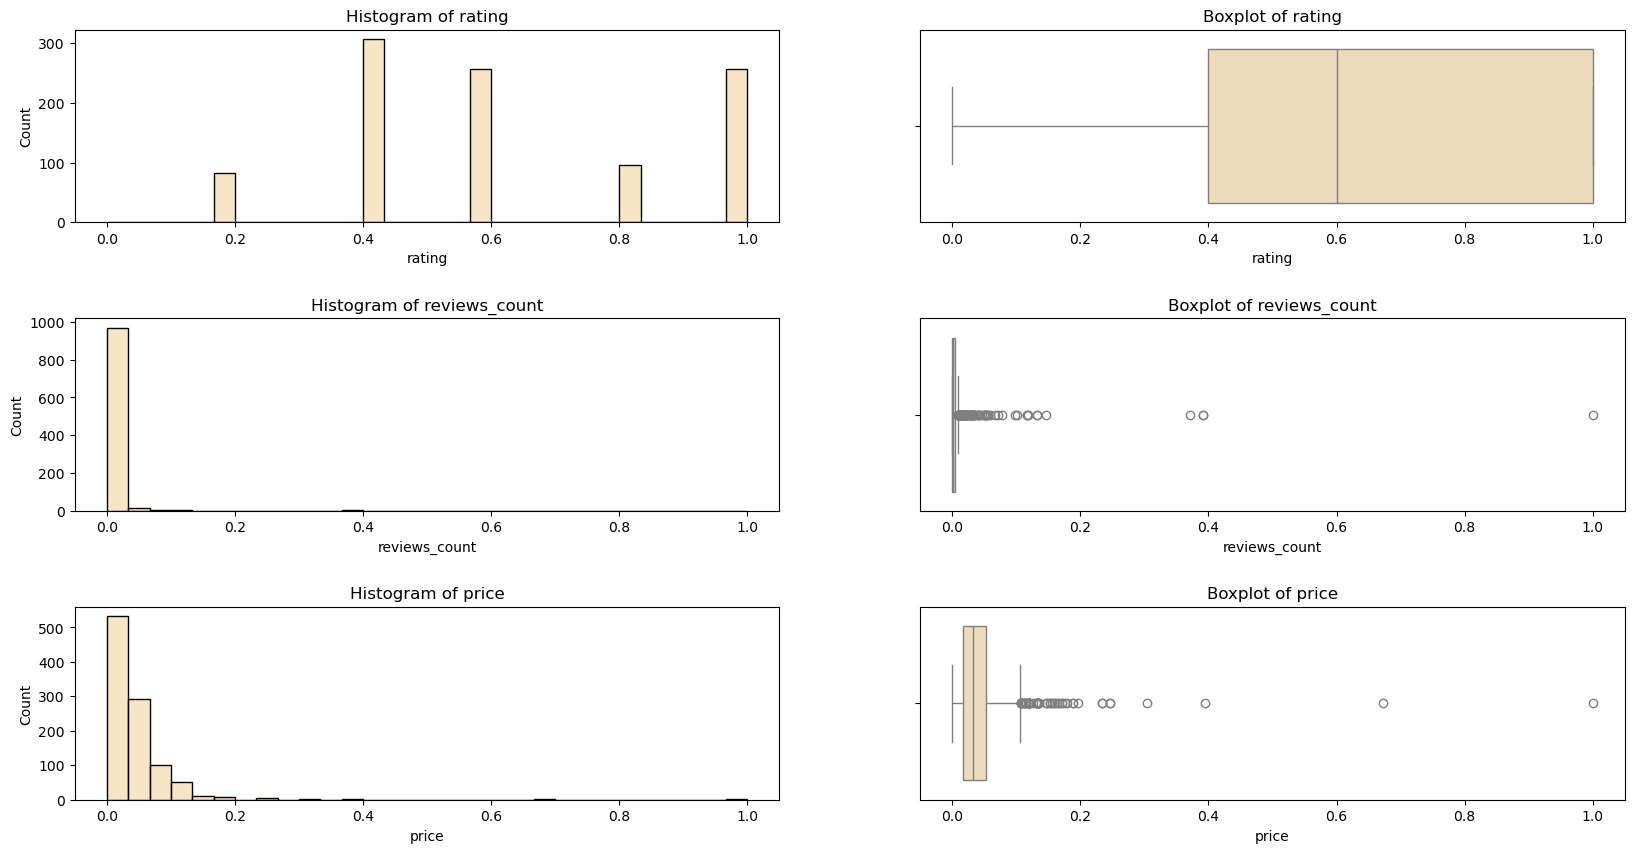

In [23]:
# 2. Distribution in numerical features

numeric_features = ['rating', 'reviews_count', 'price']

fig, axes = plt.subplots(len(numeric_features), 2, figsize=(20, 10))

for n, feat in enumerate(numeric_features):
    color = "wheat"

    # Histogram
    sns.histplot(product_df_scaled[feat], bins=30, kde=False, color=color, ax=axes[n, 0])
    axes[n, 0].set_title(f'Histogram of {feat}')

    # Boxplot
    sns.boxplot(x=product_df_scaled[feat], color=color, ax=axes[n, 1])
    axes[n, 1].set_title(f'Boxplot of {feat}')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

## 3. Feature Engineering

### (a) Benefit and Allergies

In [24]:
# 1. Enrich `product_df` by taking the benefit and allergies from `ingredients_df` lookup from the ingredient list that already pre-processed to ensure alignment between the two dataframe


# Map the benefit to skin concern to standardise user input
concern_mapping = {
    'pregnancy': 'pregnancy',
    'radiance': 'dull skin',
    'texture': 'texture',
    'dark circles': 'pigmentation',
    'eye bags': 'pigmentation',
    'impaired skin barrier': 'impaired skin barrier',
    'redness': 'redness',
    'fine lines': 'wrinkles',
    'wrinkles': 'wrinkles',
    'blackheads': 'pores',
    'acne': 'acne',
    'elasticity': 'impaired skin barrier',
    'pigmentation': 'pigmentation',
    'enlarged pores': 'pores',
    'post blemish marks': 'pigmentation',
    'uv protection': 'uv protection',
    
    'oily': 'oily',
    'dry and dehydrated skin': 'dry',
    'combination': 'combination',
    'anyone': 'normal'
}

# Map the allergies to reduced and standardise to user input
allergies_mapping = {
    'pregnancy': 'pregnancy',
    'impaired skin barrier': 'impaired skin barrier',
    'gluten allery': 'gluten allery',
    'vegan': 'vegan',

    'oily': 'oily',
    'dry dehydrated': 'dry',
    'combination': 'combination',
    'sensitive': 'sensitive'

}

# Create function to perform the lookup
def lookup_benefit_ingredients(product_df, ingredients_df):
    
    # Create dictionaries for lookup
    good_for_map = dict(zip(ingredients_df['ingredient_name'], ingredients_df['good_for']))
    avoid_map    = dict(zip(ingredients_df['ingredient_name'], ingredients_df['avoid']))

    all_good_for = []
    all_avoid = []

    for _, row in product_df.iterrows():
        good_for_set = set()
        avoid_set = set()

        for ingredient in row['ingredients_clean']:
            
            if ingredient in avoid_map:
                val = avoid_map[ingredient]
                if val:
                    # Standardize and compile 'avoid' items
                    avoid_set.update([allergies_mapping[v] for v in val if v in allergies_mapping and v != 'nan'])


            if ingredient in good_for_map:
                val = good_for_map[ingredient]
                if val: 
                    # Standardize and compile 'good_for' items
                    good_for_set.update([concern_mapping.get(v, v) for v in val if v != 'nan'])

            # Exclude benefits that also appear in avoid (due to different ingredients that cause overlapping details and we prioritize avoid as it is more sensitive)
            filtered_good_for = good_for_set - avoid_set

        all_good_for.append(list(filtered_good_for))
        all_avoid.append(list(avoid_set))
    
    product_df['benefit'] = all_good_for
    product_df['avoid'] = all_avoid

    return product_df


In [25]:
# Implement the lookup between product ingredient to the benefit and allergies (avoid)
product_df = lookup_benefit_ingredients(product_df, ingredients_df)
product_df[['name', 'ingredients', 'ingredients_clean', 'benefit', 'avoid']].head()

,name,ingredients,ingredients_clean,benefit,avoid
0,palmers shea butter body oil 250ml,"Glycine Soja (Soybean) Oil, Isopropyl Myristat...","[acetylarginyltryptophyl diphenylglycine, dipe...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, oily, dry, impaired ski..."
1,la roche posay cicaplast baume b5 100ml,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...,"[acetylarginyltryptophyl diphenylglycine, alph...","[dull skin, pregnancy, pores, acne, dry, textu...","[impaired skin barrier, combination, oily]"
2,avene thermal spring water 300ml mist for sen...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...,[avene thermal water],"[dry, texture, dull skin, impaired skin barrie...",[]
3,palmers shimmer radiance body oil 150ml,"Mineral Oil (Paraffinum Liquidum), Isopropyl P...","[ascorbyl palmitate, heptapeptide-15 palmitate...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, dry, impaired skin barr..."
4,cerave moisturising cream 454g,2021500 - INGREDIENTS: AQUA / WATER • GLYCERI...,"[caprooyl phytosphingosine, caprooyl sphingosi...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, gluten allery, impaired..."


### (b) Product type

In [26]:
import re
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import torch

# Load sentence transformer model for fuzzy matching
model = SentenceTransformer('all-MiniLM-L6-v2')

def classify_product(text, classify_dict, rule_weight=0.7, fuzzy_weight=0.3, threshold=0.2):

    # Concat key and values from mapping to enrich embedding
    concat_key_values = []
    max_hits_dict = {}
    for key, keywords in classify_dict.items():
        combined_text = key + ' ' + ' '.join(keywords)
        concat_key_values.append(combined_text)
        max_hits_dict[key] = len(keywords)

    classify_dict_keys = list(classify_dict.keys())
    classify_dict_embeddings = model.encode(concat_key_values, convert_to_tensor=True)
    text_lower = text.lower() if isinstance(text, str) else ''
    
    # Approach 1: Finding exact match
    rule_scores = Counter()
    for product_type, keywords in classify_dict.items():
        hits = sum(bool(re.search(r'\b' + re.escape(x.lower()) + r'\b', text_lower)) for x in keywords)
        max_hits = max_hits_dict[product_type]

        # Normalize the score
        rule_scores[product_type] = hits / max_hits if max_hits > 0 else 0
    

    # Approach 2: Finding partial match with text embedding
    text_embedding = model.encode(text_lower, convert_to_tensor=True)
    cos_sim = util.cos_sim(text_embedding, classify_dict_embeddings).squeeze() 
    fuzzy_scores = {classify_dict_keys[i]: cos_sim[i].item() for i in range(len(classify_dict_keys))}
    
    # Combine scores from both approach
    combined_scores = {x: rule_weight * rule_scores.get(x, 0) + fuzzy_weight * fuzzy_scores.get(x, 0)
                       for x in classify_dict.keys()}
    
    # Choose result with the highest score
    best_type = max(combined_scores, key=combined_scores.get)

     # Check confidence
    best_type = max(combined_scores, key=combined_scores.get)
    if combined_scores[best_type] < threshold:
        return "other"
    else:
        return best_type


In [27]:
# Create product types dictionary with its keywords
product_types = {
    'cleanser': ['cleanser', 'face wash', 'cleansing'],
    'toner': ['toner', 'facial toner', 'hydrating toner'],
    'facial mist': ['mist', 'face mist'],
    'serum': ['serum', 'concentrate', 'ampoule'],
    'moisturizer': ['moisturizer', 'cream', 'lotion'],
    'sunscreen': ['sunscreen', 'spf', 'sun protection'],
    'face mask': ['mask', 'sheet mask', 'clay mask'],
    'exfoliator': ['exfoliator', 'scrub', 'peel'],
    'eye cream': ['eye cream', 'eye gel', 'eye treatment'],
    'chemical peel': ['chemical peel', 'peeling solution'],
    'lip care': ['lip', 'lip balm', 'lip treatment'],
    'acne treatment': ['acne', 'pimple', 'blemish'],
    'hyperpigmentation treatment': ['hyperpigmentation', 'uneven', 'dark spot'],
    'anti-aging': ['fine lines', 'wrinkles', 'anti-aging'],
    'face oil': ['face oil', 'facial oil']
}

In [28]:
# Classify each product by type
product_df['concat_name_description'] = product_df['name'].fillna('') + ' ' + product_df['general_information'].fillna('')
product_df['product_type'] = product_df['concat_name_description'].apply(lambda x: classify_product(x, product_types))
product_df[['name', 'product_type']].head()

,name,product_type
0,palmers shea butter body oil 250ml,other
1,la roche posay cicaplast baume b5 100ml,lip care
2,avene thermal spring water 300ml mist for sen...,facial mist
3,palmers shimmer radiance body oil 150ml,other
4,cerave moisturising cream 454g,moisturizer


### (c) Product formulation

In [29]:
# Create product formulation dictionary with its keywords
product_formulation = {
    'water': ['water', 'aqua', 'toner', 'spray', 'essence', 'mist', 'serum'],
    'oil': ['oil', 'facial oil', 'plant oil', 'jojoba', 'argan'],
    'cream': ['cream', 'lotion', 'moisturise', 'milk', 'gel'],
    'solid': ['solid', 'stick', 'soap', 'bar', 'wax'],
    'balm': ['balm', 'ointment', 'lip balm'],
    'foam': ['foam', 'foaming', 'mousse', 'lather'],
    'mask/patch/wipes': ['face mask', 'sheet mask', 'mask', 'patch', 'acne patch', 'wipes']
}

In [31]:
# Classify each product by formulation
product_df['formulation'] = product_df['concat_name_description'].apply(lambda x: classify_product(x, product_formulation))
product_df[['name', 'formulation']].head()

,name,formulation
0,palmers shea butter body oil 250ml,oil
1,la roche posay cicaplast baume b5 100ml,balm
2,avene thermal spring water 300ml mist for sen...,water
3,palmers shimmer radiance body oil 150ml,oil
4,cerave moisturising cream 454g,cream


In [34]:
# Re-apply scaling to the transformed dataset
for col in numeric_features:
    product_df[col+"_raw"] = product_df[col].copy()

product_df = min_max_scale(product_df, numeric_features)

# Select essential columns for concise modeling dataset
product_df = product_df[['name', 'price', 'rating', 'reviews_count', 'price_raw', 'rating_raw', 'reviews_count_raw', 'general_information', 'ingredients_clean',
                        'benefit', 'avoid','product_type', 'formulation', 'url', 'img_url']].copy()

# Rename column for clean naming
product_df = product_df.rename(columns={"ingredients_clean":"ingredients"})

In [36]:
# Save the clean data
product_df.to_csv('products_list_clean.csv', index=False)
ingredients_df.to_csv('ingredients_list_clean.csv', index=False)

# 5. EDA: After Data Preparation

We perform another exploration using the cleaned dataset to obtain more relevant information about the products separation.

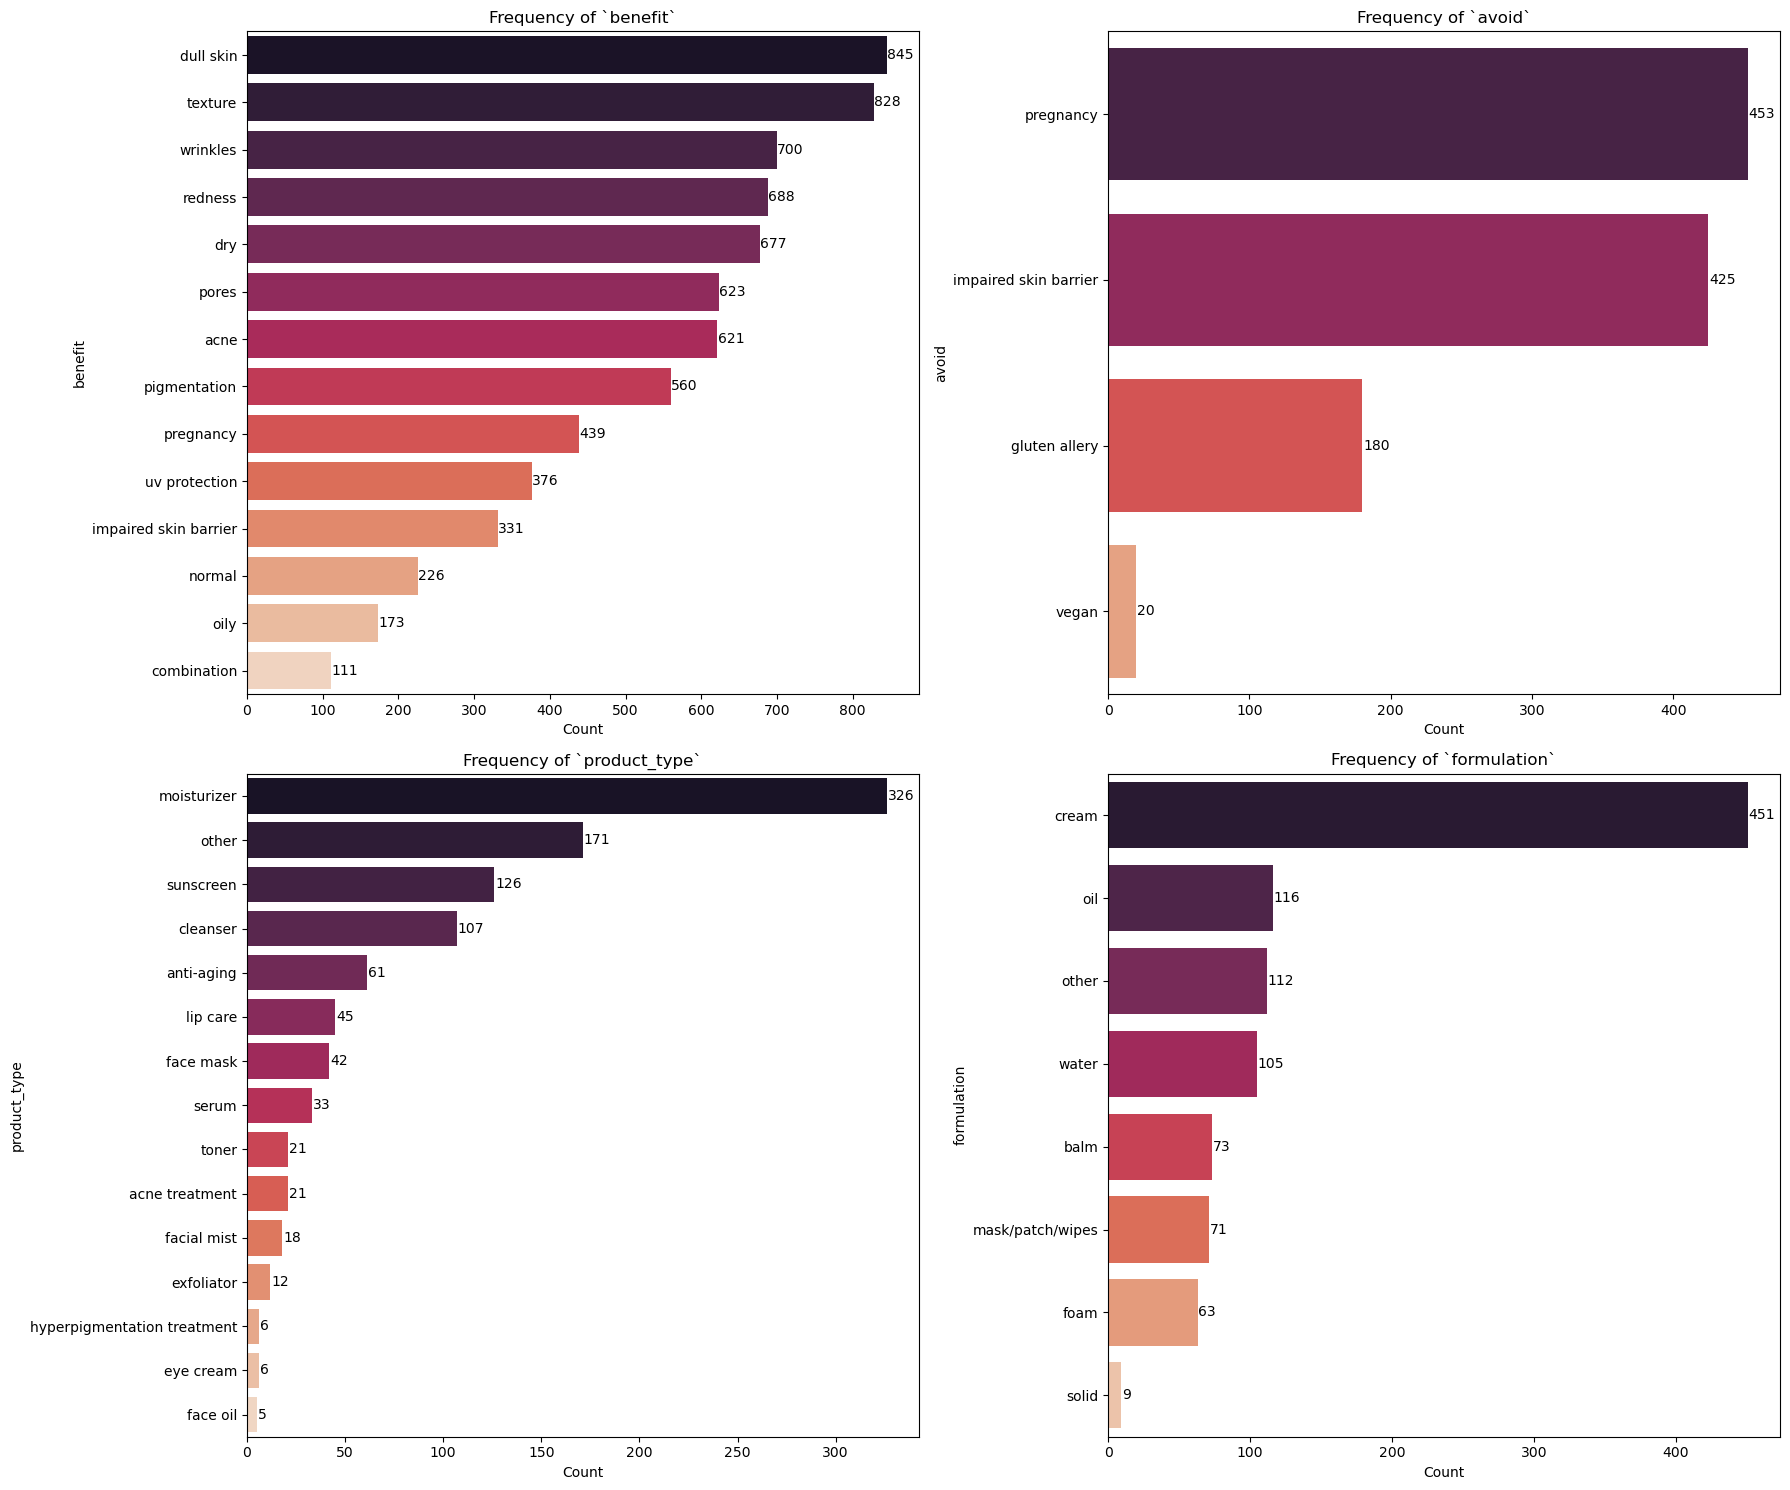

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = ['benefit', 'avoid', 'product_type', 'formulation']

fig, axes = plt.subplots(2, 2, figsize=(18, 15))  
axes = axes.flatten()

for i, feat in enumerate(categorical_features):
    ax = axes[i]  
    
    all_values = product_df[feat].explode()

    if feat == 'avoid':
        to_remove = ['oily', 'dry', 'sensitive', 'combination']
        all_values = all_values[~all_values.isin(to_remove)]

    top_values = all_values.value_counts()

    col_palette = sns.color_palette("rocket", n_colors=len(top_values))

    sns.barplot(
        x=top_values.values,
        y=top_values.index,
        hue=top_values.index,
        ax=ax,
        palette=col_palette
    )

    # Add count labels 
    for j, (value, name) in enumerate(zip(top_values.values, top_values.index)):
        ax.text(value + 0.5, j, str(value), va='center')


        
    ax.set_title(f"Frequency of `{feat}`")
    ax.set_xlabel("Count")
    ax.set_ylabel(f"{feat}")


plt.tight_layout()
plt.show()


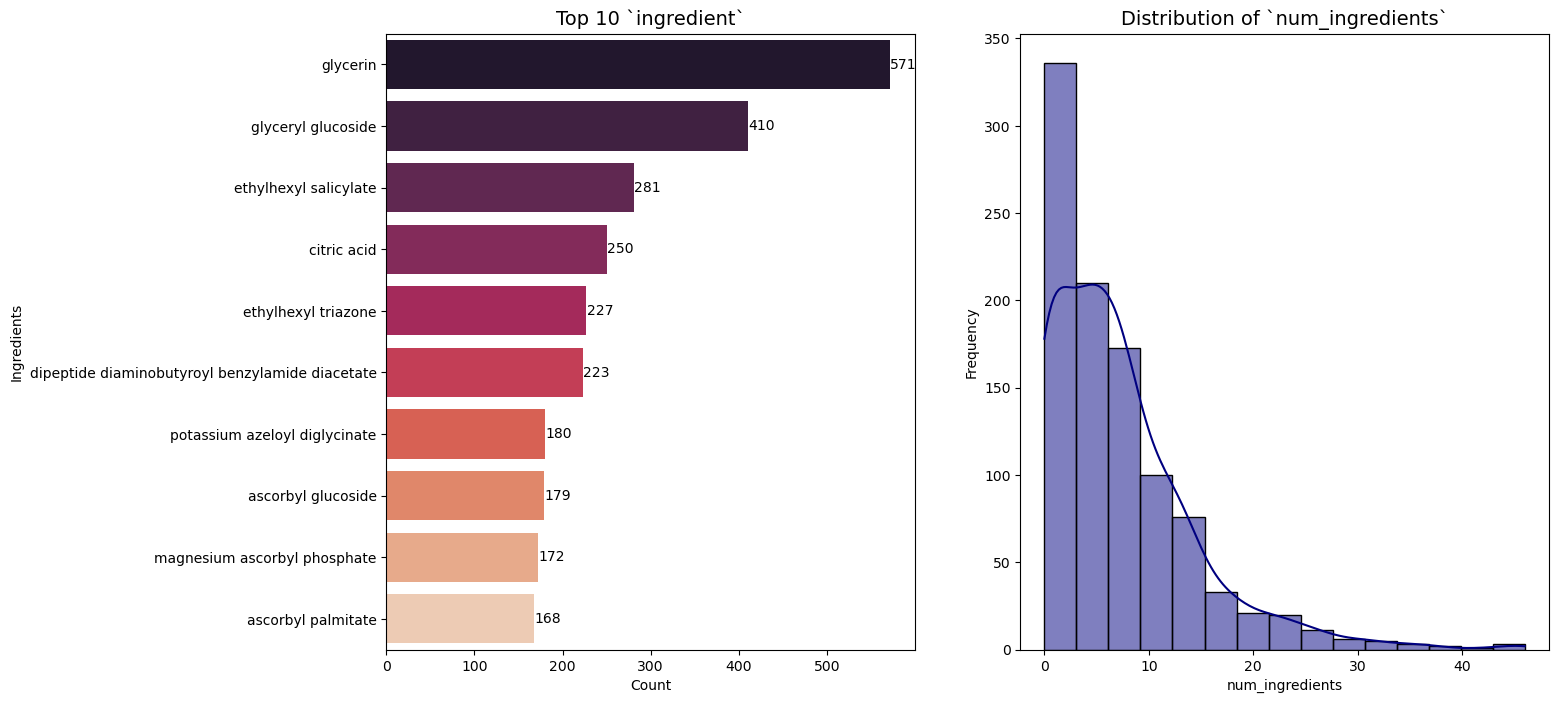

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

# Count number of ingredients per row
product_df['num_ingredients'] = product_df['ingredients'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Bar plot
all_values = product_df['ingredients'].explode()
top_values = all_values.value_counts().head(10)

# Brown gradient palette
col_palette = sns.color_palette("rocket", n_colors=len(top_values))

sns.barplot(
    x=top_values.values,
    y=top_values.index,
    hue=top_values.index,
    ax=axes[0],
    palette=col_palette
)

# Add count labels
for j, (value, name) in enumerate(zip(top_values.values, top_values.index)):
    axes[0].text(value + 0.5, j, str(value), va='center')

axes[0].set_title(f"Top 10 `ingredient`", fontsize=14)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Ingredients")

# Histogram
sns.histplot(product_df['num_ingredients'].dropna(), kde=True, ax=axes[1], color='navy', bins=15)
axes[1].set_title(rf"Distribution of `num_ingredients`", fontsize=14)
axes[1].set_xlabel("num_ingredients")
axes[1].set_ylabel("Frequency")

plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


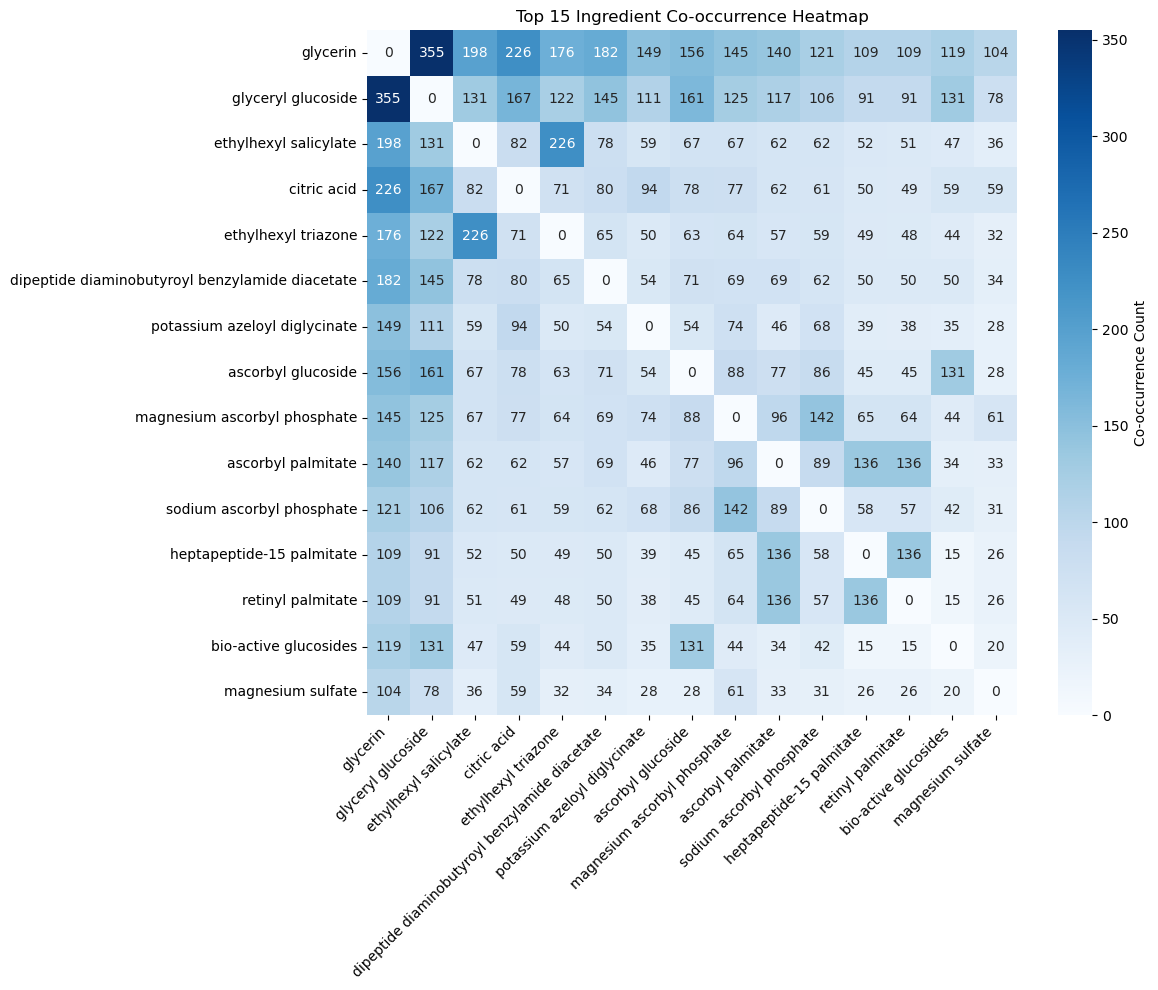

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of ingredients to space-separated strings
ingredient_strings = product_df['ingredients'].apply(lambda x: ";".join(x))

# Vectorize
vectorizer = CountVectorizer(
    tokenizer=lambda x: [tok for tok in x.split(";") if tok.strip() != ""],
    binary=True
)

X = vectorizer.fit_transform(ingredient_strings)

# Co-occurrence matrix
cooc_matrix = (X.T @ X).toarray()
np.fill_diagonal(cooc_matrix, 0)

# Get top N ingredients by frequency
ingredient_counts = X.sum(axis=0).A1
top_n = 15
top_indices = ingredient_counts.argsort()[::-1][:top_n]
top_ingredients = [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Subset co-occurrence matrix
top_matrix = cooc_matrix[np.ix_(top_indices, top_indices)]

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(top_matrix, 
            xticklabels=top_ingredients, 
            yticklabels=top_ingredients, 
            cmap="Blues", 
            annot=True, 
            fmt="d",
            cbar_kws={'label': 'Co-occurrence Count'})
plt.title(f"Top {top_n} Ingredient Co-occurrence Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


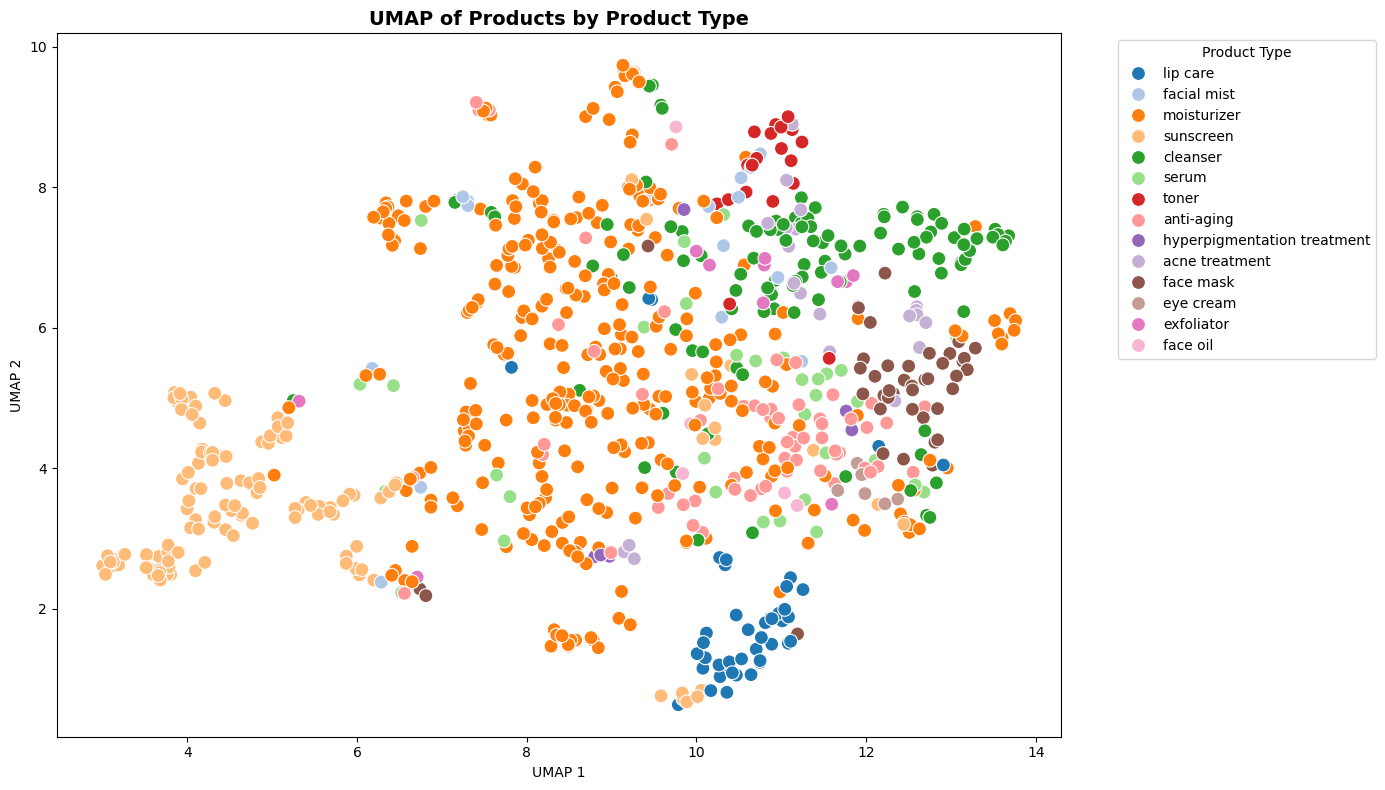

In [50]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude products with 'other' type
product_df_filtered = product_df[product_df['product_type'] != 'other'].reset_index(drop=True)
product_df_filtered['concat_name_description'] = product_df_filtered['name'] + product_df_filtered['general_information']

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(product_df_filtered['concat_name_description'].tolist(), normalize_embeddings=True)

# Reduce dimensionality
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# Plot by product type
plt.figure(figsize=(14,8))
sns.scatterplot(
    x=emb_2d[:,0],
    y=emb_2d[:,1],
    hue=product_df_filtered['product_type'],
    palette=sns.color_palette("tab20", 14),
    s=100
)
plt.title("UMAP of Products by Product Type", fontsize=14, fontweight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Product Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()


# 6. Modeling

We begin modeling using the three-stage hybrid recommendation system. We are still exploring the most accurate approach, and it will be updated over time.

In [37]:
# Load clean data set
import pandas as pd

clean_product_df = pd.read_csv('products_list_clean.csv')
clean_product_df.iloc[:,:-2].head()

,name,price,rating,reviews_count,price_raw,rating_raw,reviews_count_raw,general_information,ingredients,benefit,avoid,product_type,formulation
0,palmers shea butter body oil 250ml,0.012221,1.0,0.000154,6.99,5.0,5,palmers shea formula body oil soothes and nour...,"['acetylarginyltryptophyl diphenylglycine', 'd...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'oily', 'dry', 'imp...",other,oil
1,la roche posay cicaplast baume b5 100ml,0.087814,0.4,0.020918,36.99,4.7,544,multirepairing hydrating balm for dry skin cic...,"['acetylarginyltryptophyl diphenylglycine', 'a...","['dull skin', 'pregnancy', 'pores', 'acne', 'd...","['impaired skin barrier', 'combination', 'oily']",lip care,balm
2,avene thermal spring water 300ml mist for sen...,0.024820,0.6,0.028585,11.99,4.8,743,the unique and constant composition of avne th...,['avene thermal water'],"['dry', 'texture', 'dull skin', 'impaired skin...",[],facial mist,water
3,palmers shimmer radiance body oil 150ml,0.019780,0.8,0.000231,9.99,4.9,7,palmers cocoa butter formula shimmer radiance ...,"['ascorbyl palmitate', 'heptapeptide-15 palmit...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'dry', 'impaired sk...",other,oil
4,cerave moisturising cream 454g,0.060097,0.4,0.059481,25.99,4.7,1545,rich cream for dry to very dry skin rich ceram...,"['caprooyl phytosphingosine', 'caprooyl sphing...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'gluten allery', 'i...",moisturizer,cream


In [ ]:
import pandas as pd
import torch
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### Define Recommendation System Architecture
### Consist of three main steps: bi-encoder semantic similarity, constaints-based filtering, and neural network re-ranking

class HybridRecommendationSystem:
    def __init__(self, bi_encoder_size='light', text_encoder_size='light'):
        
        # Set device
        self.device = "mps" if torch.backends.mps.is_available() else "cpu"
        print(f"Device: {self.device}")
        
        # Encoder options for text embeddings
        self.bi_encoder_options = {
            'ultralight': 'all-MiniLM-L6-v2',
            'light': 'paraphrase-MiniLM-L3-v2',
            'balanced': 'all-mpnet-base-v2',
            'heavy': 'intfloat/e5-large-v2'
        }
        
        # Load bi-encoder for semantic search
        bi_model_name = self.bi_encoder_options.get(bi_encoder_size, 'paraphrase-MiniLM-L3-v2')
        self.bi_encoder = SentenceTransformer(bi_model_name, device=self.device)
        
        # Load text encoder for neural network
        text_model_name = self.bi_encoder_options.get(text_encoder_size, 'paraphrase-MiniLM-L3-v2')
        self.text_encoder = SentenceTransformer(text_model_name, device=self.device)
        
        # Preprocessing components
        self.scalers = {}
        self.encoders = {}
        self.mlb_encoders = {}
        self.feature_names = []
        self.neural_model = None
    
    ### 1. Create dictionary of user profile
    def create_user_profile(self, skin_type, skin_problems, allergies, preferred_formulation, budget, product_types):

        return {
            'skin_type': skin_type,
            'skin_problems': skin_problems,
            'allergies': allergies,
            'preferred_formulation': preferred_formulation,
            'budget': budget,
            'product_types': product_types
        }
    
    ### 2. Concatenated user profile details into a single text for embedding
    def build_user_text(self, profile):

        parts = []
        
        if profile.get('skin_type'):
            skin_types = profile['skin_type'] if isinstance(profile['skin_type'], list) else [profile['skin_type']]
            parts.append(f"Skin type: {', '.join(skin_types)}")
        
        if profile.get('skin_problems'): 
            parts.append(f"Skin problems: {', '.join(profile['skin_problems'])}")
        
        if profile.get('product_types'): 
            parts.append(f"Product type: {', '.join(profile['product_types'])}")
        
        if profile.get('preferred_formulation'):
            pf = profile['preferred_formulation'] if isinstance(profile['preferred_formulation'], list) else [profile['preferred_formulation']]
            parts.append(f"Prefers: {', '.join(pf)} formulation")
        
        return ". ".join(parts)
    
    ### 3. Concatenated product details into a single text for embedding (x_embedding)
    def build_product_texts(self, product_df):

        texts = []
        for _, row in product_df.iterrows():
            parts = []
            if pd.notna(row.get('name')): 
                parts.append(f"Product: {row['name']}")
            
            if pd.notna(row.get('benefit')): 
                parts.append(f"Benefits: {row['benefit']}")

            if pd.notna(row.get('general_information')):
                parts.append(f"Product information: {row['general_information']}")
            
            texts.append(". ".join(parts))
        
        return texts

    ### 4. Transform each product detais into a vector of structured features for neural network (x_structured)
    def fit_transform_features(self, product_df):
        features, feature_names = [], []
        
        # Numerical features
        for col in ['price_raw', 'rating_raw', 'reviews_count_raw']:
            if col in product_df.columns:
                scaler = MinMaxScaler()
                values = product_df[col].fillna(0).values.reshape(-1, 1)
                features.append(scaler.fit_transform(values))
                feature_names.append(f"{col}_scaled")

                self.scalers[col] = scaler
        
        # Categorical features
        for col in ['product_type', 'formulation']:
            if col in product_df.columns:
                le = LabelEncoder()
                values = product_df[col].fillna("unknown")
                features.append(le.fit_transform(values).reshape(-1,1).astype(float))
                feature_names.append(f"{col}_encoded")

                self.encoders[col] = le
        
        # Multi-label features
        for col in ['benefit', 'avoid']:
            if col in product_df.columns:
                # processed_data = self.process_text_lists(product_df[col])
                mlb = MultiLabelBinarizer()
                encoded = mlb.fit_transform(product_df[col])
            
                features.append(encoded.astype(float))
                feature_names.extend([f"{col}_{cls}" for cls in mlb.classes_])

                self.mlb_encoders[col] = mlb
        
        self.feature_names = feature_names
        X = np.hstack(features) if features else np.array([]).reshape(len(product_df), 0)
        
        return X
        
    ### 5. Apply constraint-based filtering
    def apply_hard_constraints(self, product_df, profile, candidate_indices=None):

        filtered = product_df.iloc[candidate_indices].copy() if candidate_indices is not None else product_df.copy()
        
        # a. Filter product types based on user request
        if profile.get("product_types"):
            types = [pt.lower() for pt in profile["product_types"]]
            filtered = filtered[filtered["product_type"].str.lower().isin(types)]

        # b. Filter product formulation based on user request
        if profile.get("preferred_formulation"):
            forms = [pf.lower() for pf in (profile["preferred_formulation"] if isinstance(profile["preferred_formulation"], list) else [profile["preferred_formulation"]])]
            filtered = filtered[filtered["formulation"].str.lower().isin(forms)]
        
        # c. Filter product that contains user's allergies
        if profile.get("allergies"):
            for allergen in profile["allergies"]:
                mask = ~filtered["avoid"].str.contains(allergen, case=False, na=False)
                filtered = filtered[mask]

        # d. Filter product with price above user budget
        if profile.get('budget') is not None:
            filtered = filtered[filtered["price_raw"] <= profile["budget"]]
        
        return filtered.index.tolist() if candidate_indices else filtered

    ### 6. Calculate the target score to define the single objective in neural network training
    def compute_target_scores(self, product_df, user_profile):

        n = len(product_df)
        scores = np.zeros(n)
        
        # a. Rating component
        scores += 0.2 * product_df['rating']
        
        # b. Popularity component
        scores += 0.3 * product_df['reviews_count']
        
        # c. Benefit match
        if user_profile.get('skin_problems'):
            def benefit_match(text):
                if pd.isna(text): 
                    return 0
                benefit_str = str(text).lower()
                user_problems = [p.lower().strip() for p in user_profile['skin_problems']]
                matches = sum(1 for problem in user_problems if problem in benefit_str)
                return matches / len(user_problems)
            
            scores += 0.5 * product_df['benefit'].apply(benefit_match)
        
        return np.clip(scores, 0, 1)
    
    ### 7. The architecture of the neural network to perform re-ranking
    def build_neural_reranker(self, structured_dim, embedding_dim, dropout_rate=0.3):

        # Inputs
        structured_input = layers.Input(shape=(structured_dim,), name='structured_input')
        embedding_input = layers.Input(shape=(embedding_dim,), name='embedding_input')
        
        # Structured features branch
        s = layers.Dense(128, activation='relu')(structured_input)
        s = layers.BatchNormalization()(s)
        s = layers.Dropout(dropout_rate)(s)
        
        # Text embedding branch
        e = layers.Dense(128, activation='relu')(embedding_input)
        e = layers.BatchNormalization()(e)
        e = layers.Dropout(dropout_rate)(e)
        
        # Combine all branches
        combined = layers.Concatenate()([s, e])
        
        # Hidden layers
        x = layers.Dense(256, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate/2)(x)
        
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        
        # Output layer
        output = layers.Dense(1, activation='sigmoid', name='rerank_score')(x)
        
        model = Model([structured_input, embedding_input], output)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        
        return model
    
    ###  Training loop using the three step recommendation system
    def recommend_products(self, product_df, user_profile, top_k=5, retrieval_k=50, 
                          train_neural_net=True, epochs=20, batch_size=16, validation_split=0.2):

        print("Step 1: Bi-encoder semantic similarity")
        
        # Build product embeddings for bi-encoder
        product_texts = self.build_product_texts(product_df)
        product_embeddings = self.bi_encoder.encode(product_texts, convert_to_tensor=True, show_progress_bar=True)
        
        # Build user profile embedding
        user_text = self.build_user_text(user_profile)
        user_emb = self.bi_encoder.encode(user_text, convert_to_tensor=True)
        
        # Semantic similarity
        hits = util.semantic_search(user_emb, product_embeddings, top_k=retrieval_k)[0]
        candidate_indices = [hit['corpus_id'] for hit in hits]
        initial_scores = {hit['corpus_id']: hit['score'] for hit in hits}
        
        print(f"Result from step 1: {len(candidate_indices)} products")
        
        print("Step 2: Constraint-based filtering")
        
        # Apply hard constraints
        filtered_indices = self.apply_hard_constraints(product_df, user_profile, candidate_indices)
        
        if not filtered_indices:
            print("No products match the hard constraints!")
            return pd.DataFrame()
        
        print(f"Result from step 2: {len(filtered_indices)} products")
        
        print("Step 3: Neural network re-ranking")
        
        if train_neural_net and len(filtered_indices) > 5:

            # Filter products for neural network
            filtered_df = product_df.iloc[filtered_indices].copy()
            
            # Create structured features
            X_structured = self.fit_transform_features(filtered_df)
            
            # Create text embeddings for neural network
            filtered_product_texts = self.build_product_texts(filtered_df)
            X_text = self.text_encoder.encode(filtered_product_texts, convert_to_tensor=True)
            
            # Compute targets
            y_target = self.compute_target_scores(filtered_df, user_profile)
            
            # Build and train neural reranker
            self.neural_model = self.build_neural_reranker(
                X_structured.shape[1], X_text.shape[1]
            )
            
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            ]
            
            history = self.neural_model.fit(
                [X_structured, X_text], y_target,
                epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                callbacks=callbacks, verbose=1
            )
            
            # Generate neural network predictions
            neural_scores = self.neural_model.predict([X_structured, X_text]).flatten()
            
            # Combine scores: 60% neural network and 40% bi-encoder similarity
            final_scores = [(idx, 0.6 * ns + 0.4 * initial_scores.get(idx, 0.0)) 
                          for idx, ns in zip(filtered_indices, neural_scores)]
            
            print(f"Retrieved final score using bi-encoder score and neura network re-ranking")
            
        else:
            print("Insufficient data for neural network and only using bi-encoder score.")
            final_scores = [(idx, initial_scores.get(idx, 0.0)) for idx in filtered_indices]
        
        # Sort by final scores
        reranked = sorted(final_scores, key=lambda x: x[1], reverse=True)

        # Final results
        results = []
        for idx, score in reranked[:top_k]:
            row = product_df.iloc[idx]
            results.append({
                "name": row["name"],
                "product_type": row["product_type"],
                "formulation": row["formulation"],
                "price": row["price"],
                "rating": row["rating"],
                "benefit": row["benefit"],
                "avoid": row.get("avoid", ""),
                "ingredients": str(row.get("ingredients", ""))[:100] + "..." if len(str(row.get("ingredients", ""))) > 100 else str(row.get("ingredients", "")),
                "final_score": float(score),
                "bi_encoder_score": initial_scores.get(idx, 0.0)
            })
        
        results_df = pd.DataFrame(results)

        print(f"Process finished with top {len(results_df)} recommendations")
        
        return results_df

In [3]:
### Main function to execute the recommendation system for a single or multiple user profiles
def run_hybrid_recommendations(product_df, user_profiles, top_k=5, bi_encoder_size='light', text_encoder_size='light'):

    # Initialize the recommendation system
    hybrid_system = HybridRecommendationSystem(
        bi_encoder_size=bi_encoder_size,
        text_encoder_size=text_encoder_size
    )
    
    user_profiles_dict = []
    if isinstance(user_profiles, pd.DataFrame):
        for _, row in user_profiles.iterrows():
            profile = hybrid_system.create_user_profile(row['skin_type'],
                                                        row['skin_problems'], 
                                                        row['skin_allergies'],
                                                        row['preferred_formulation'],
                                                        row['budget'],
                                                        row['product_types'])

            user_profiles_dict.append(profile)

    elif isinstance(user_profiles, dict):
        user_profiles_dict.append(user_profiles)
    
    all_recommendations = []
    
    for i, profile in enumerate(user_profiles_dict):

        recommendations = hybrid_system.recommend_products(
            product_df=product_df,
            user_profile=profile,
            top_k=top_k,
            retrieval_k=50,
            train_neural_net=True,
            epochs=20,
            batch_size=16
        )
        
        rec_list = recommendations.to_dict(orient='records') if not recommendations.empty else []
        all_recommendations.append(rec_list)
    
    return all_recommendations


## Synthetic Data

We generate synthetic data to evaluate the model, using the popularity distribution from product catalog as weights to create synthetic data that reflects product demands.

In [ ]:
from collections import Counter
import pandas as pd
import numpy as np

### Generating synthetic data based on product catalog as reference

# List of options
skin_types_vocab = {"oily", "dry", "combination", "sensitive", "normal"}
skin_problems_vocab = {"redness", "impaired skin barrier", "wrinkles", "acne",
                       "pores", "pigmentation", "texture", "dull skin", "uv protection"}
allergies_vocab = {"pregnancy", "impaired skin barrier", "gluten allergy", "vegan",
                   "oily", "dry", "combination", "sensitive"}

# Calculate weighted counts from product catalog
def weighted_counts(product_df):

    w_skin_types = Counter()
    w_skin_problems = Counter()
    w_allergies = Counter()
    w_formulation = Counter()
    w_product_types = Counter()

    for _, row in product_df.iterrows():
        w = row["reviews_count"] if "reviews_count" in row else 1

        benefits = row.get("benefit", [])
        avoids = row.get("avoid", [])
        formulation = str(row.get("formulation", "")).lower()
        ptype = str(row.get("product_type", "")).lower()

        for b in benefits:
            if b in skin_types_vocab:
                w_skin_types[b] += w
            elif b in skin_problems_vocab:
                w_skin_problems[b] += w

        for a in avoids:
            if a in allergies_vocab:
                w_allergies[a] += w

        if formulation:
            w_formulation[formulation] += w

        if ptype:
            w_product_types[ptype] += w

    return {
        "skin_types": w_skin_types,
        "skin_problems": w_skin_problems,
        "allergies": w_allergies,
        "formulation": w_formulation,
        "product_types": w_product_types,
    }

# Generate user profiles
def generate_user_profiles(product_df, n_users=100):
    weights = weighted_counts(product_df)

    def sample_one(counter):
        items, probs = zip(*[(k, v / sum(counter.values())) for k, v in counter.items()])
        return np.random.choice(items, p=probs)

    def sample_many(counter, k=2):
        items, probs = zip(*[(k, v / sum(counter.values())) for k, v in counter.items()])
        return list(np.random.choice(items, size=k, replace=False, p=probs))

    users = []
    for i in range(n_users):
        # Skin type: 1 value
        skin_type = sample_one(weights["skin_types"])

        # Skin problems: up to 2 values
        skin_problems = sample_many(weights["skin_problems"], k=np.random.randint(1, 3))

        # Allergies: up to 2 values
        allergies = sample_many(weights["allergies"], k=np.random.randint(1, 3))

        # Formulation: 1 value
        formulation = sample_one(weights["formulation"])

        # Product types: 1 value
        product_types = sample_one(weights["product_types"])

        # Budget from price distribution
        bins = [0, 10, 30, 60, float("inf")]
        labels = ["low", "medium", "high", "luxury"]
        product_df["price_bin"] = pd.cut(product_df["price_raw"], bins=bins, labels=labels, include_lowest=True)
        budget_dist = product_df.groupby("price_bin")["reviews_count"].sum().to_dict()
        items, probs = zip(*[(k, v / sum(budget_dist.values())) for k, v in budget_dist.items()])
        budget = np.random.choice(items, p=probs)

        users.append({
            "user_id": f"user_{i+1}",
            "skin_type": skin_type,
            "skin_problems": ", ".join(skin_problems),
            "allergies": allergies,
            "preferred_formulation": formulation,
            "budget": budget,
            "product_types": ", ".join(product_types),
        })

    return pd.DataFrame(users)
